# PUBG Games Classifier: Machine Learning Class

https://www.kaggle.com/c/pubg-finish-placement-prediction/data

## Data fields
## Below is a list of all variables in the data set

- DBNOs - Number of enemy players knocked.
- assists - Number of enemy players this player damaged that were killed by teammates.
- boosts - Number of boost items used.
- damageDealt - Total damage dealt. Note: Self inflicted damage is subtracted.
- headshotKills - Number of enemy players killed with headshots.
- heals - Number of healing items used.
- Id - Player’s Id
- killPlace - Ranking in match of number of enemy players killed.
- killPoints - Kills-based external ranking of player. (Think of this as an Elo ranking where only kills matter.) If there is a value other than -1 in rankPoints, then any 0 in killPoints should be treated as a “None”.
- killStreaks - Max number of enemy players killed in a short amount of time.
- kills - Number of enemy players killed.
- longestKill - Longest distance between player and player killed at time of death. This may be misleading, as downing a player and driving away may lead to a large longestKill stat.
- matchDuration - Duration of match in seconds.
- matchId - ID to identify match. There are no matches that are in both the training and testing set.
- matchType - String identifying the game mode that the data comes from. The standard modes are “solo”, “duo”, “squad”, “solo-fpp”, “duo-fpp”, and “squad-fpp”; other modes are from events or custom matches.
- rankPoints - Elo-like ranking of player. This ranking is inconsistent and is being deprecated in the API’s next version, so use with caution. Value of -1 takes place of “None”.
- revives - Number of times this player revived teammates.
- rideDistance - Total distance traveled in vehicles measured in meters.
- roadKills - Number of kills while in a vehicle.
- swimDistance - Total distance traveled by swimming measured in meters.
- teamKills - Number of times this player killed a teammate.
- vehicleDestroys - Number of vehicles destroyed.
- walkDistance - Total distance traveled on foot measured in meters.
- weaponsAcquired - Number of weapons picked up.
- winPoints - Win-based external ranking of player. (Think of this as an Elo ranking where only winning matters.) If there is a value other than -1 in rankPoints, then any 0 in winPoints should be treated as a “None”.
- groupId - ID to identify a group within a match. If the same group of players plays in different matches, they will have a different groupId each time.
- numGroups - Number of groups we have data for in the match.
- maxPlace - Worst placement we have data for in the match. This may not match with numGroups, as sometimes the data skips over placements.
- winPlacePerc - The target of prediction. This is a percentile winning placement, where 1 corresponds to 1st place, and 0 corresponds to last place in the match. It is calculated off of maxPlace, not numGroups, so it is possible to have missing chunks in a match.

![](https://ksassets.timeincuk.net/wp/uploads/sites/54/2018/02/Pubg-920x518.jpg)

PlayerUnknown's Battlegrounds (PUBG) is an online multiplayer battle royale game developed and published by PUBG Corporation. 
- In the game, up to one hundred players parachute onto an island and scavenge for weapons and equipment to kill others while avoiding getting killed themselves. 
- The available safe area of the game's map decreases in size over time, directing surviving players into tighter areas to force encounters. 
- The last player or team standing wins the round.

## Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
import statsmodels.api as sm
import gc
from random import shuffle
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn import neighbors
from sklearn import linear_model
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

In [3]:
# Center all plots by CSS
from IPython.core.display import HTML

HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    margin:auto;
    }
.prompt 
    display:none;
}  
</style>
""")

## Data Import

In [4]:
pd.set_option("display.max_columns",30)
pd.set_option('display.float_format', lambda x: '%.2f' %x)
data = pd.read_csv('data/train_V2.csv')

# Drop row with NaN 'winPlacePerc' value (found out during EDA, this one row is odd and should be removed)
data.drop(2744604, inplace=True)
data_copy = data.copy()

In [5]:
data = data_copy.copy()

## Glimpse the Data

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4446965 entries, 0 to 4446965
Data columns (total 29 columns):
Id                 object
groupId            object
matchId            object
assists            int64
boosts             int64
damageDealt        float64
DBNOs              int64
headshotKills      int64
heals              int64
killPlace          int64
killPoints         int64
kills              int64
killStreaks        int64
longestKill        float64
matchDuration      int64
matchType          object
maxPlace           int64
numGroups          int64
rankPoints         int64
revives            int64
rideDistance       float64
roadKills          int64
swimDistance       float64
teamKills          int64
vehicleDestroys    int64
walkDistance       float64
weaponsAcquired    int64
winPoints          int64
winPlacePerc       float64
dtypes: float64(6), int64(19), object(4)
memory usage: 1017.8+ MB


In [7]:
data.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,1241,0,0,0.00,1306,squad-fpp,28,26,-1,0,0.00,0,0.00,0,0,244.80,1,1466,0.44
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,0,0,0,0.00,1777,squad-fpp,26,25,1484,0,0.00,0,11.04,0,0,1434.00,5,0,0.64
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,0,0,0,0.00,1318,duo,50,47,1491,0,0.00,0,0.00,0,0,161.80,2,0,0.78
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,0,0,0,0.00,1436,squad-fpp,31,30,1408,0,0.00,0,0.00,0,0,202.70,3,0,0.17
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,0,1,1,58.53,1424,solo-fpp,97,95,1560,0,0.00,0,0.00,0,0,49.75,2,0,0.19


In [8]:
data.describe()

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
count,4446965.00,4446965.00,4446965.00,4446965.00,4446965.00,4446965.00,4446965.00,4446965.00,4446965.00,4446965.00,4446965.00,4446965.00,4446965.00,4446965.00,4446965.00,4446965.00,4446965.00,4446965.00,4446965.00,4446965.00,4446965.00,4446965.00,4446965.00,4446965.00,4446965.00
mean,0.23,1.11,130.72,0.66,0.23,1.37,47.60,505.01,0.92,0.54,23.00,1579.51,44.50,43.01,892.01,0.16,606.12,0.00,4.51,0.02,0.01,1154.22,3.66,606.46,0.47
std,0.59,1.72,170.78,1.15,0.60,2.68,27.46,627.50,1.56,0.71,50.97,258.74,23.83,23.29,736.65,0.47,1498.34,0.07,30.50,0.17,0.09,1183.50,2.46,739.70,0.31
min,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,133.00,2.00,1.00,-1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.00,0.00,0.00,0.00,0.00,24.00,0.00,0.00,0.00,0.00,1367.00,28.00,27.00,-1.00,0.00,0.00,0.00,0.00,0.00,0.00,155.10,2.00,0.00,0.20
50%,0.00,0.00,84.24,0.00,0.00,0.00,47.00,0.00,0.00,0.00,0.00,1438.00,30.00,30.00,1443.00,0.00,0.00,0.00,0.00,0.00,0.00,685.60,3.00,0.00,0.46
75%,0.00,2.00,186.00,1.00,0.00,2.00,71.00,1172.00,1.00,1.00,21.32,1851.00,49.00,47.00,1500.00,0.00,0.19,0.00,0.00,0.00,0.00,1976.00,5.00,1495.00,0.74
max,22.00,33.00,6616.00,53.00,64.00,80.00,101.00,2170.00,72.00,20.00,1094.00,2237.00,100.00,100.00,5910.00,39.00,40710.00,18.00,3823.00,12.00,5.00,25780.00,236.00,2013.00,1.00


In our DataSet we have roughly 4.5 milion observations and 33 variables. Lots of them are highly skewed, and at the first glimpse we can see variables that will need to be removed in future due to the fact that their can be strongly correlated with eachother - as far as our domain knowledge tells us.

# Explanatory Data Analysis (EDA)

In this part we will perform some Data Engineering, Visualisations etc. to make our variables more efficient for future purposes

- Firstly we have splitted categorical variable: "matchType" to two new variables:
    - isFPP which indicates if game mode was forced as First Player Perspective (harder to play)
    - matchTypeIgnoreFPP which indicates type of the match (doesn't include FPP info)

![](https://www.gre.ac.uk/__data/assets/image/0011/1191953/analysis-banner.jpg)

## Feature Engineering

In [9]:
# Delete rows with unusual match types
goodMatchTypes = ["squad-fpp","duo-fpp","squad","solo-fpp","duo","solo"]
data = data.query("matchType in @goodMatchTypes")
data['matchType'].value_counts()
data.reset_index()

# Create column is first person perspective
fppList = ["squad-fpp","duo-fpp","solo-fpp"]
data['isFPP'] = data['matchType'].apply(lambda x: x in fppList).astype(int)

# Create column that ignores the FPP sub-type
data["matchTypeIgnoreFPP"]= data["matchType"].str.replace('-fpp', "") 

# Drop useless columns
cols = [0,1]
data.drop(data.columns[cols],axis=1,inplace=True)

# Move columns around
data = data[['winPlacePerc','matchType','matchTypeIgnoreFPP', 'isFPP', 'winPoints','matchId','matchDuration','numGroups','vehicleDestroys',
       'assists', 'boosts', 'damageDealt', 'DBNOs', 'headshotKills', 'heals',
       'killPlace', 'killPoints', 'kills', 'killStreaks', 'longestKill',
        'maxPlace', 'rankPoints','revives', 'rideDistance', 'roadKills', 'swimDistance', 'teamKills','walkDistance', 'weaponsAcquired']]

## Plotting

We plotted as much as possible to see the data in visual form, mostly because we are visual learners and it's easier to interpret for us than just standard table

### Match Type

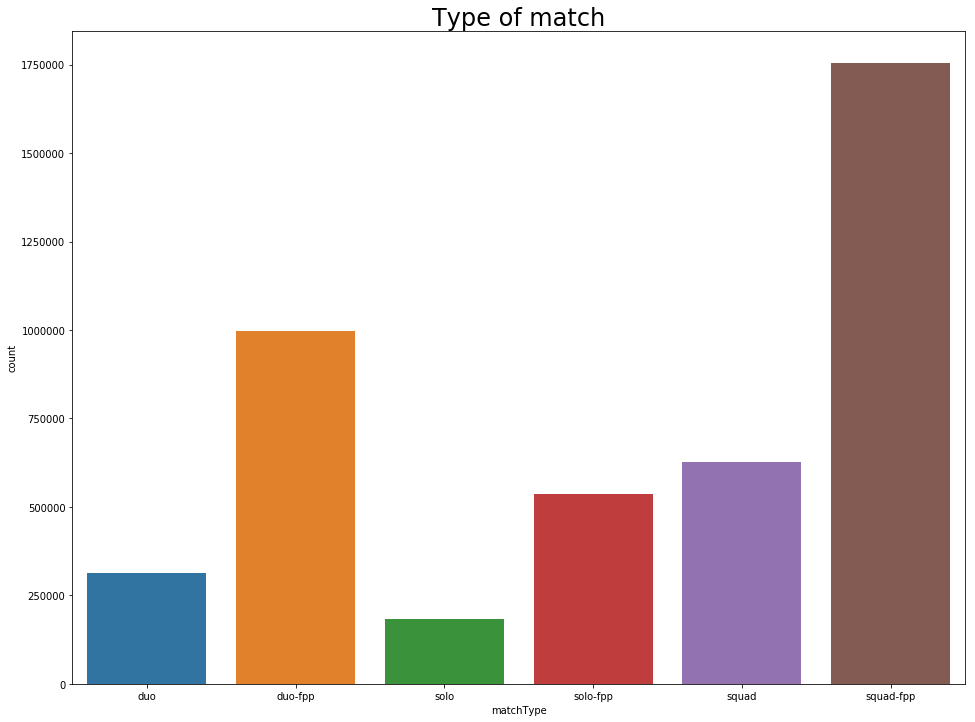

In [10]:
plt.figure(figsize=(16,12))
sns.countplot(data['matchType'].astype('str').sort_values())
plt.title("Type of match",fontsize=24)
plt.show()

We can see that most of our observations are from squad matches, and also that duo + solo does not exceed number of squads

/Users/Kornel/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


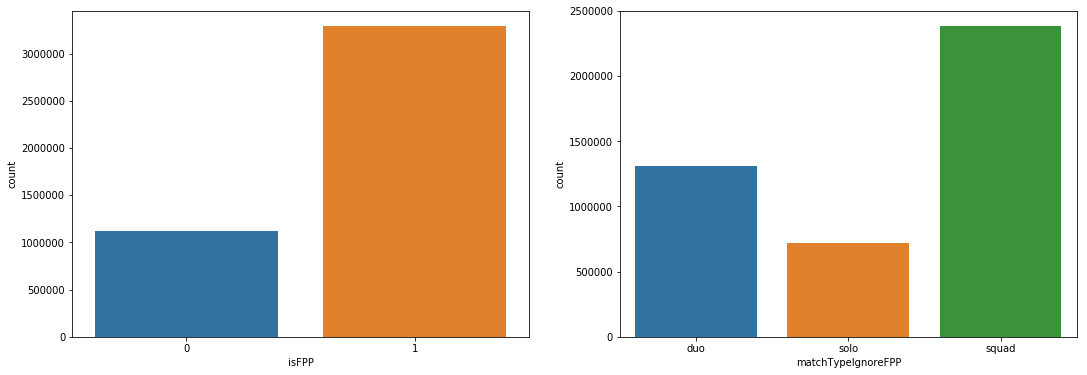

In [11]:
fig, ax = plt.subplots(1,2,figsize=(18,6))
sns.countplot(data['isFPP'].astype('str').sort_values(), ax=ax[0])
sns.countplot(data['matchTypeIgnoreFPP'].astype('str').sort_values(),ax=ax[1])
fig.show()

- As we expected, most of the matches are not FPP
- As we can also see, solo and squad matches outpefrorms in quantity the solo group, yet we want to estimate top 25 players so including squads (4ppl) and duo(2ppl) will give us inconsistent results

In [12]:
# Droping observations which consist squad or duo games
data = data.query('matchTypeIgnoreFPP!="squad" & matchTypeIgnoreFPP!="duo"')
data = data.reset_index()
data.drop(data.columns[0],axis=1,inplace=True)

In [13]:
display(data.head(5))
print(len(data))

,winPlacePerc,matchType,matchTypeIgnoreFPP,isFPP,winPoints,matchId,matchDuration,numGroups,vehicleDestroys,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,maxPlace,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,walkDistance,weaponsAcquired
0,0.19,solo-fpp,solo,1,0,6dc8ff871e21e6,1424,95,0,0,0,100.00,0,0,0,45,0,1,1,58.53,97,1560,0,0.00,0,0.00,0,49.75,2
1,0.74,solo-fpp,solo,1,1500,292611730ca862,1967,92,0,0,0,8.54,0,0,0,48,1000,0,0,0.00,96,-1,0,2004.00,0,0.00,0,1089.00,6
2,0.88,solo-fpp,solo,1,1462,2c30ddf481c52d,1886,94,0,0,1,324.20,0,1,5,5,986,4,1,49.83,97,-1,0,1228.00,0,76.84,0,2050.00,6
3,0.82,solo-fpp,solo,1,0,07948d723b9c0f,1371,95,0,0,3,254.30,0,0,12,13,0,2,1,36.00,96,1536,0,2367.00,0,15.29,0,1787.00,3
4,0.35,solo-fpp,solo,1,0,bc2faecb77e5ec,1425,94,0,0,0,136.90,0,0,0,37,0,1,1,22.83,96,1500,0,0.00,0,0.00,0,270.70,1


718704


### Kills

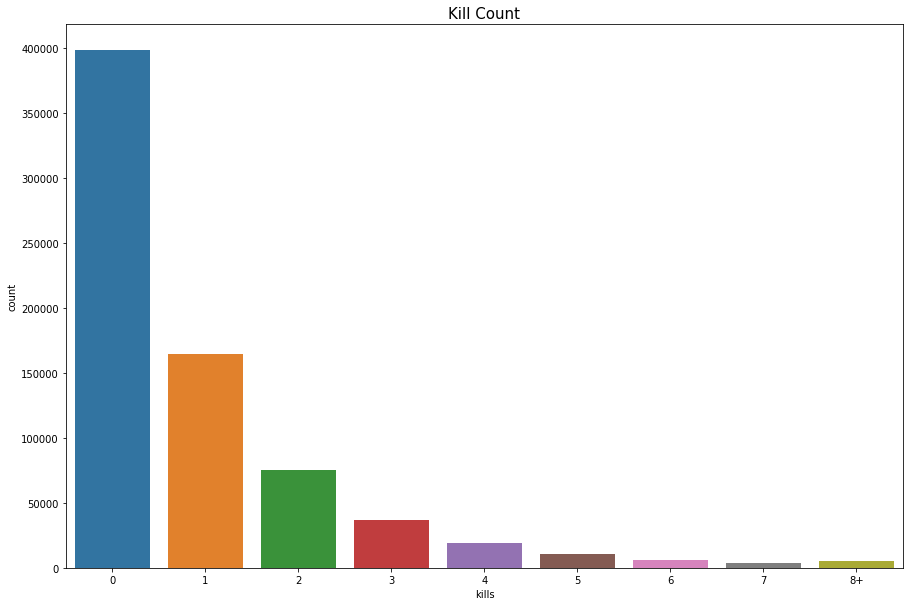

In [14]:
dataKills = data.copy()
dataKills.loc[dataKills['kills'] > dataKills['kills'].quantile(0.99)] = '8+'
plt.figure(figsize=(15,10))
sns.countplot(dataKills['kills'].astype('str').sort_values())
plt.title("Kill Count",fontsize=15)
plt.show()

### Below we have checked the distribution of our considered dependent variables

/Users/Kornel/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


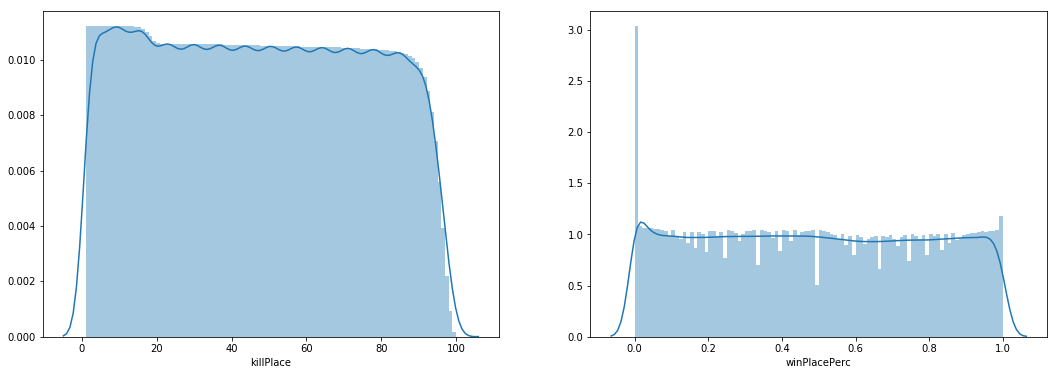

In [15]:
fig, ax = plt.subplots(1,2,figsize=(18,6))
sns.distplot(data["killPlace"], bins = 100, ax=ax[0])
sns.distplot(data['winPlacePerc'], bins = 100,ax=ax[1])
fig.show()

We can see that winPlacePerc is not equally distributed... but why? If in game is always 100 people, at the end each of them should take some place from 0-100 right? 

We've been searching what is wrong with this data, and with helping hand of one of kaggle users we found out that this is due to the fact that NOT EVERY GAME IS FULL!!!

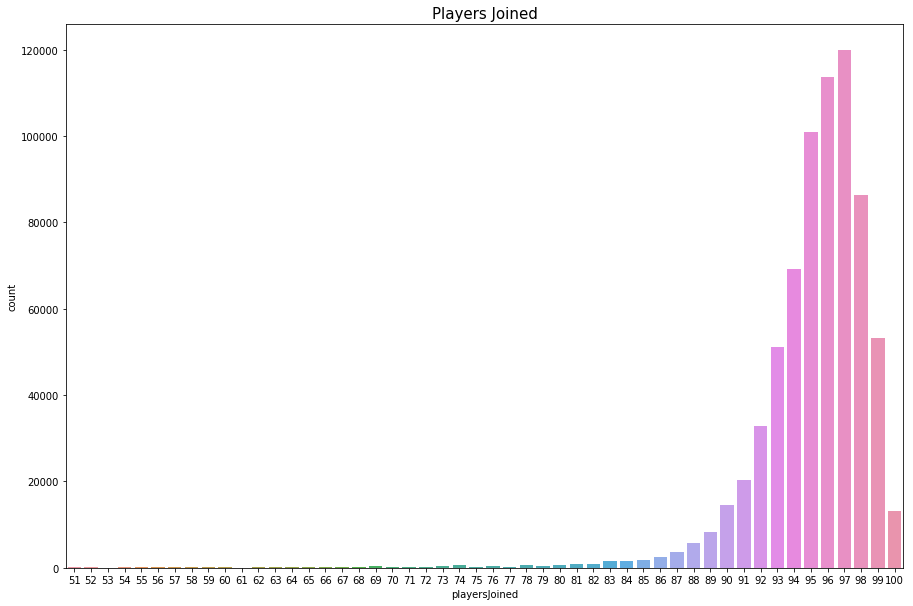

In [16]:
data['playersJoined'] = data.groupby('matchId')['matchId'].transform('count')
dataJoined = data.copy()
dataJoined = dataJoined[dataJoined['playersJoined']>49]
plt.figure(figsize=(15,10))
sns.countplot(dataJoined['playersJoined'])
plt.title("Players Joined",fontsize=15)
plt.show()

- In next steps we need to get rid of matchId, because it breaks our kernel

In [17]:
data.drop(data.columns[5],axis=1,inplace=True)

### Here we made plots for every variable, with all outliers and irregularities to check how the distribution looks like and how to deal with some variables next

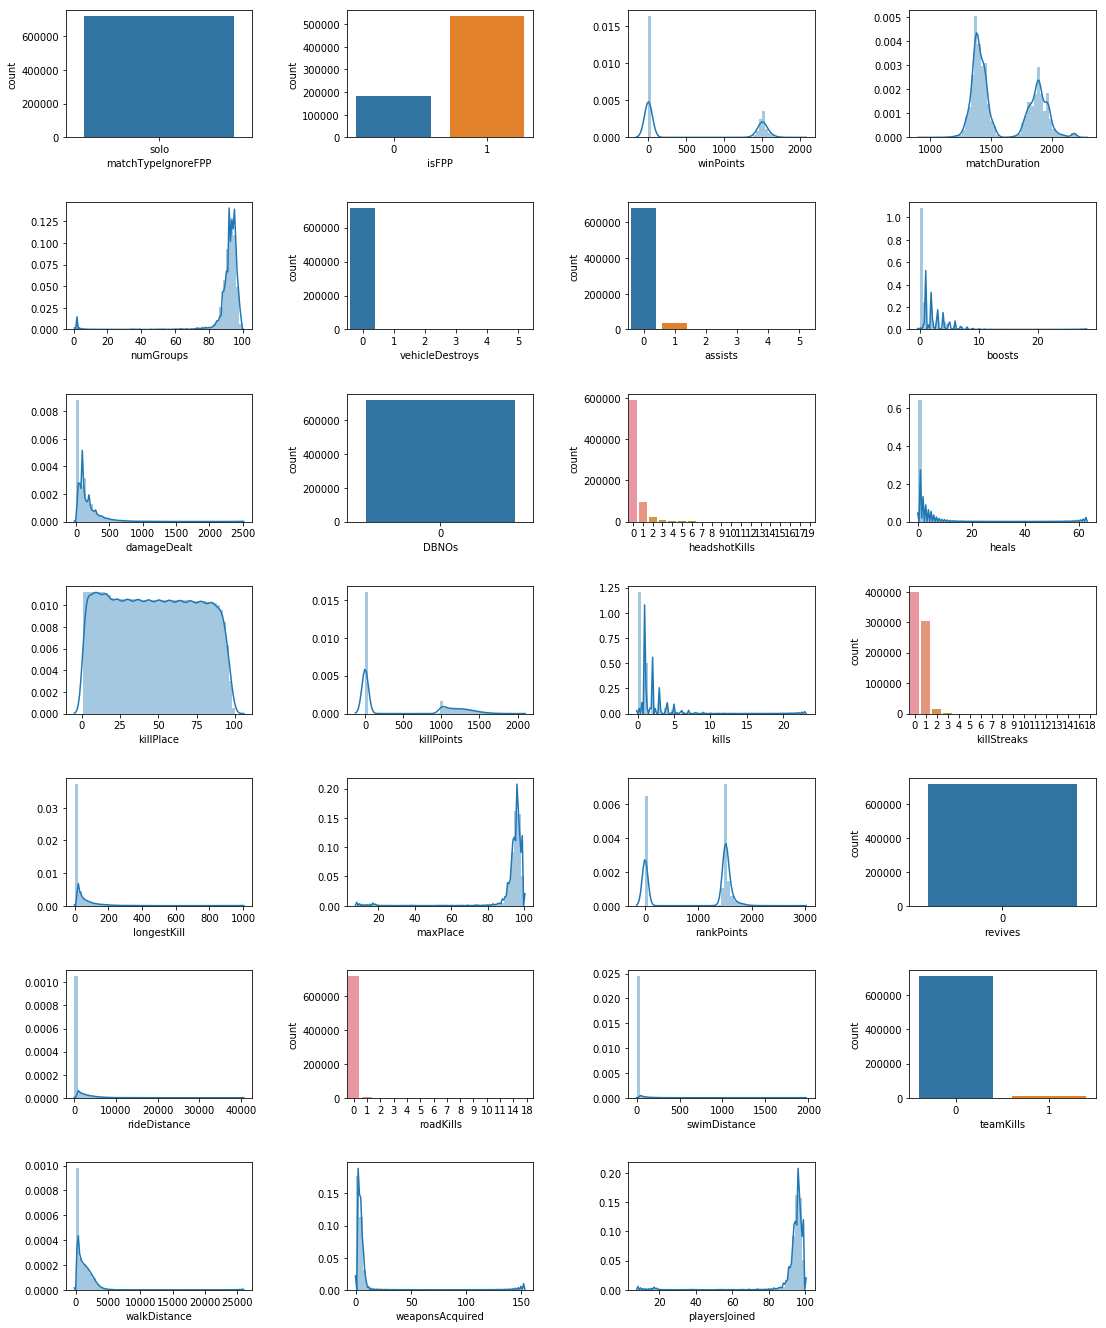

In [18]:
# Let's take a look at the distribution of all variables
fig = plt.figure(figsize=(16,40))

for i, col in enumerate(data.columns[2:]):
    ax = fig.add_subplot(15, 4, i + 1)
    if len(data[col].unique()) > 20:
        sns.distplot(data[col])
    else:
        sns.countplot(data[col])

fig.tight_layout(pad=3)
fig.savefig('plot.png')

## Data Transformation
At this point we will clear the data even more:
- We will remove afk players (those ones who didn't even walk 5 meters)
- We will introduce our variable isNewbie, which indicates person who are not Ranked in PUBG Rank System

In [18]:
# Let's remove afk players
len(data.query("walkDistance < 5"))/len(data)
data = data.query("walkDistance > 5")

# If someone has 0 win points it means that they played less than 10 matches
data['isNewbie'] = data['winPoints'].apply(lambda x: x > 5).astype(int)

## Ranking System in PUBG

![alt text](obrazek_1.jpg)

Next we drop useless variables due to errors, and inconsistency. We also need to trim our data (a.k.a remove outliers), and change some variables to binary due to their distribution

Variables removed:
- killPlace - place in a kill ranking
- longestKill - inconsistent
- maxPlace - Correlated with type of game
- numGroups -  Correlated with type of game
- rankPoints - inconsistent

In [19]:
columnsToDrop = ["killPlace","longestKill", "maxPlace", "numGroups", "rankPoints","revives","DBNOs"]
data.drop(columns = columnsToDrop, inplace=True)

# Trimming outliers
data.loc[data.walkDistance>4000,'walkDistance'] = 4000
data.loc[data.damageDealt>500,'damageDealt'] = 500
data.loc[data.heals>6,'heals'] = 6
data.loc[data.kills>5,'kills'] = 5
data.loc[data.killStreaks>2,'killStreaks'] = 2
data.loc[data.weaponsAcquired>10,'weaponsAcquired'] = 10
data.loc[data.boosts>5,'boosts'] = 5

# Changing variables to binary
data.loc[data.assists>1,'assists'] = 1
data.loc[data.headshotKills>1,'headshotKills'] = 1
data.loc[data.roadKills>1,'roadKills'] = 1
data.loc[data.teamKills>1,'teamKills'] = 1
data.loc[data.vehicleDestroys>1,'vehicleDestroys'] = 1
data.loc[data.rideDistance>1,'rideDistance'] = 1
data.loc[data.swimDistance>1,'swimDistance'] = 1
data.loc[data.winPlacePerc>=0.75,'winPlacePerc'] = 1
data.loc[data.winPlacePerc<0.75,'winPlacePerc'] = 0

# Rename
data = data.rename(index=str, columns={"rideDistance": "driver", "swimDistance": "swimmer"})

## Investigating Correlations among variables

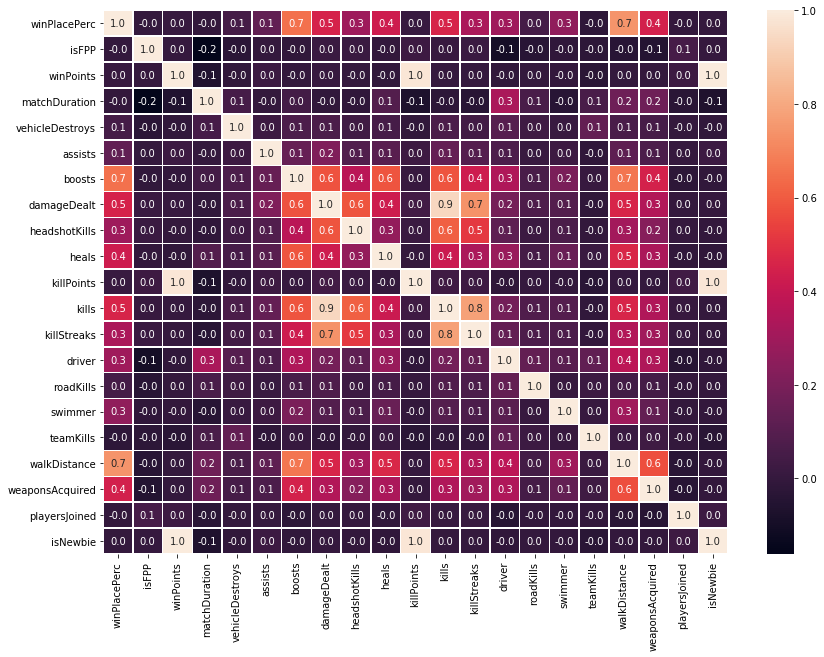

In [20]:
f,ax = plt.subplots(figsize=(14, 10))
sns.heatmap(data.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)
plt.show()

In [21]:
dataNoCorrelation = data.drop(columns = ['walkDistance','killStreaks', 'killPoints', 'damageDealt','winPoints'])

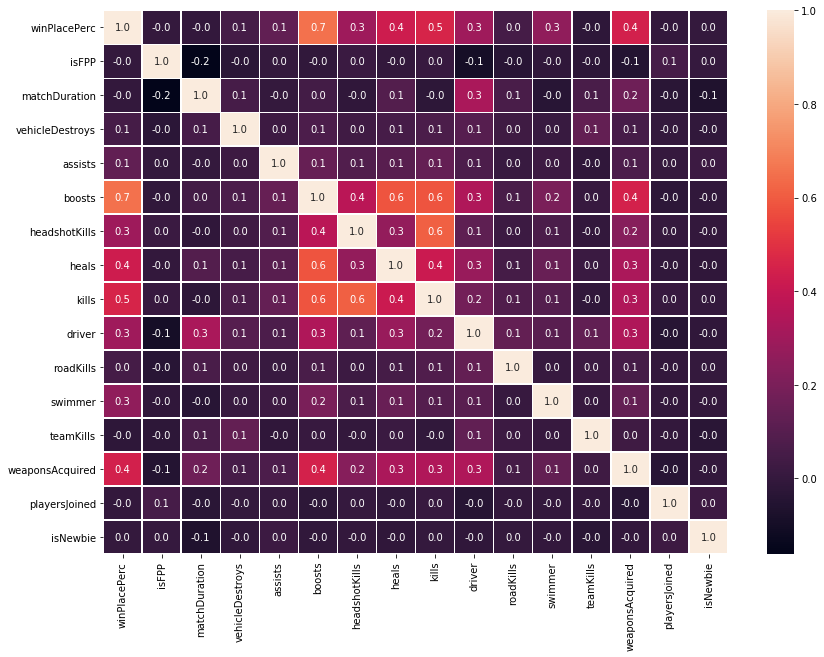

In [22]:
# Correlation Matrix after cleaning
f,ax = plt.subplots(figsize=(14, 10))
sns.heatmap(dataNoCorrelation.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)
plt.show()

Investigating Correlation Matrices, we can see that some variables are suprisingly correlated:
- winPlacePerc with boosts (0.7)
- heals with boosts (0.6)
- kills with headshotKills (0.6) ~ not suprising at all

Suprisingly nothing is significantly correlated with winPlacePerc (which is now binary and indicate a person which won the game a.k.a best of 100 players)

## Checking for obvious patterns among chosen variables

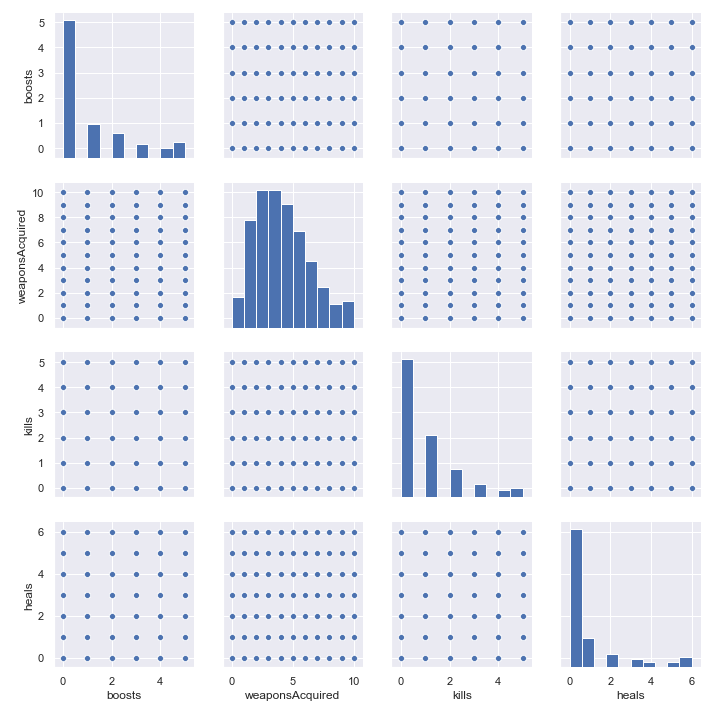

In [41]:
sns.set()
cols = ['boosts', 'weaponsAcquired', 'kills',"heals"]
sns.pairplot(data[cols], height = 2.5)
plt.show()

# Model Estimation

In this part we will try to estimate our models: KNN, SVM, LogitRegression, RandomForest and Linear&Quadratic SVD.

What we've done here:

- Feature selection to fit our model best
- Undersampling for training set to make classification possible
- Hyperparameters tunning as for imbalanced data it's crucial
- Base our conclusions on Precision and Recall, due to the fact that Accuracy here is useless
- Time Efficiency testing for each algorithm

Lets begin!

![](https://cdn.lynda.com/course/645050/645050-636700308369503992-16x9.jpg)

## Splitting Data Set

- No Correlation Set

In [23]:
dataNoCorrelation = dataNoCorrelation.sample(frac=1).reset_index(drop=True)
trainSet_checkC, testSet_checkC = train_test_split(dataNoCorrelation,test_size=0.3)

- Correlated Set

In [24]:
data = data.sample(frac=1).reset_index(drop=True)
trainSet_check, testSet_check = train_test_split(data,test_size=0.3)

## Feature selection
We have to get rid of matchType, matchTypeIgnoreFPP, isFPP and matchDuration because it's strongly inconsistent with our prediction assumption. 

Hence, everyone are playing the same type of match at once, thus there is no sense to include it as independent variable to predict postion in the end-Match Ranking

In [25]:
features = trainSet_checkC.columns.tolist()
features.remove("matchType")
features.remove('matchTypeIgnoreFPP')
features.remove('isFPP')
features.remove('matchDuration')
features.remove('winPlacePerc')

- Checking proportions of the target variable

In [26]:
1-len(trainSet_checkC.query('winPlacePerc==1'))/len(trainSet_checkC)

0.7403388667338988

# Predicting on Unbalanced Data

### Estimate Trial Logit Regression to check for P-values coefficients etc

In [27]:
# Estimate the model
mod = smf.glm(formula="winPlacePerc ~ {}".format(' + '.join(features)), data=trainSet_checkC, family=sm.families.Binomial())
res = mod.fit()
predicted_logit = res.predict(testSet_checkC)
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           winPlacePerc   No. Observations:               477946
Model:                            GLM   Df Residuals:                   477932
Model Family:                Binomial   Df Model:                           13
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.5309e+05
Date:                Mon, 03 Jun 2019   Deviance:                   3.0619e+05
Time:                        23:17:28   Pearson chi2:                 4.19e+05
No. Iterations:                     6   Covariance Type:             nonrobust
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -4.9538      0.082    -60.678      0.000      -5.114      -4.794
vehicleDestroys    -0.0886      0.064     -1.374      0.169      -0.215       0.038
assists             0.5428      0.019     28.962      0.000       0.506       0.580
boosts              0.7905      0.004    202.880      0.000       0.783       0.798
headshotKills       0.0795      0.013      6.123      0.000       0.054       0.105
heals               0.0575      0.003     19.806      0.000       0.052       0.063
kills               0.2520      0.005     54.789      0.000       0.243       0.261
driver              0.4370      0.011     40.350      0.000       0.416       0.458
roadKills          -0.3144      0.059     -5.350      0.000      -0.430      -0.199
swimmer             1.6142      0.017     96.939      0.000       1.582       1.647
teamKills          -1.2142      0.045    -26.877      0.000      -1.303      -1.126
weaponsAcquired     0.2976      0.002    129.244      0.000       0.293       0.302
playersJoined       0.0100      0.001     11.780      0.000       0.008       0.012
isNewbie            0.0642      0.010      6.678      0.000       0.045       0.083
===================================================================================
"""

- It seems that we need to remove vehicleDestroys

In [28]:
features.remove('vehicleDestroys')

- Next we have to convert our Logit Regression predictions, which are in range [0;1] to Binary 0 and 1

In [29]:
predicted_logit.loc[predicted_logit>0.5]=1
predicted_logit.loc[predicted_logit<1]=0

### Making In-sample Prediction using CrossValidation with Logistic Regression and comparing to Logit out-of-sample Results

In [30]:
predicted = cross_val_predict(LogisticRegression(solver='lbfgs',max_iter=2000),dataNoCorrelation[features], dataNoCorrelation['winPlacePerc'], cv=5)
print("\nAccuracy of LogitRegressionCV:",metrics.accuracy_score(dataNoCorrelation['winPlacePerc'], predicted),"\n")
print("Summary LogitRegressionCV:\n",metrics.classification_report(dataNoCorrelation['winPlacePerc'], predicted))
print("\nAccuracy of LogitRegression (without CV):",metrics.accuracy_score(testSet_check['winPlacePerc'], predicted_logit),"\n")
print("\nSummary LogitRegression (without CV):\n",metrics.classification_report(testSet_check['winPlacePerc'], predicted_logit))


Accuracy of LogitRegressionCV: 0.8615659509651717 

Summary LogitRegressionCV:
               precision    recall  f1-score   support

         0.0       0.88      0.94      0.91    505052
         1.0       0.79      0.64      0.71    177728

    accuracy                           0.86    682780
   macro avg       0.83      0.79      0.81    682780
weighted avg       0.86      0.86      0.86    682780


Accuracy of LogitRegression (without CV): 0.6381264829081109 


Summary LogitRegression (without CV):
               precision    recall  f1-score   support

         0.0       0.74      0.79      0.76    151792
         1.0       0.26      0.21      0.23     53042

    accuracy                           0.64    204834
   macro avg       0.50      0.50      0.50    204834
weighted avg       0.62      0.64      0.63    204834



In [31]:
# Cross table
logit_cv = pd.crosstab(dataNoCorrelation['winPlacePerc'], predicted)
logit_wo_ct = pd.crosstab(testSet_check['winPlacePerc'], predicted_logit)
display(logit_cv)
print("\n")
display(logit_wo_ct)

col_0,0.0,1.0
winPlacePerc,,
0.00,473829,31223
1.00,63297,114431


col_0,0.0,1.0
winPlacePerc,,
0.00,35629,9690
1.00,12729,3485


### Conclusion: 
- We can see that it's easy to make In-sample prediction on whole Data using LogitRegression with really good results (Recall around 94% and Precision 88%)
- However, Training our data on 0.7% of observations, and then validating its Accuracy on Test Set gives us weak results (Recall and Precision respectively 79% and 74%)
- It maybe due to the fact that making In-sample predictions increase our Bias (model Fits well) but also increases our Variance (when we input new data it wont work)
- Even when we manipulate the probability treshold to classify even from 0.9% as 1 it gives no results, thus we can try to say that this data can be so random that it is hard to classify it with LogitRegression (maybe we have not enough variables?)

## KNN - will make use of the fact that KNN performs better when we include correlated variables
- We included here variables that we had to omit in LogitRegression (walkDistance, killStreaks, killPoints, damageDealt, winPoints, vehicleDestroys)

In [32]:
featuresCorrelated = data.columns.tolist()
featuresCorrelated.remove("matchType")
featuresCorrelated.remove('matchTypeIgnoreFPP')
featuresCorrelated.remove('isFPP')
featuresCorrelated.remove('matchDuration')
featuresCorrelated.remove('winPlacePerc')

In [33]:
sampleDataKNN = data.sample(100000)

In [34]:
kf = KFold(n_splits=5, shuffle=True, random_state=15)

In [35]:
probs = []
aucsKNN = []
accsKNN = []
precKNN = []
recallKNN = []

n_neighbors = 50
knn = neighbors.KNeighborsClassifier(n_neighbors, n_jobs=-1, p=2)

for train, test in kf.split(sampleDataKNN.index.values):
    knn.fit(sampleDataKNN.iloc[train][featuresCorrelated].values, sampleDataKNN.iloc[train]["winPlacePerc"].values)
    prob = knn.predict_proba(sampleDataKNN.iloc[test][featuresCorrelated].values)
    aucsKNN.append(metrics.roc_auc_score(sampleDataKNN.iloc[test]["winPlacePerc"].values, prob[:,1]))
    accsKNN.append(metrics.accuracy_score(sampleDataKNN.iloc[test]["winPlacePerc"].values, (prob[:,1]>0.5).astype(int)))
    precKNN.append(metrics.precision_score(sampleDataKNN.iloc[test]["winPlacePerc"].values, (prob[:,1]>0.5).astype(int)))
    recallKNN.append(metrics.recall_score(sampleDataKNN.iloc[test]["winPlacePerc"].values, (prob[:,1]>0.5).astype(int)))
    probs.append((prob[:,1]>0.5).astype(int))

print("KNN AUC:",np.mean(aucsKNN))
print("KNN Accuracy Score:",np.mean(accsKNN))
print("KNN Precision Score:",np.mean(precKNN))
print("KNN Recall Score:",np.mean(recallKNN))

KNN AUC: 0.9504471470663953
KNN Accuracy Score: 0.88849
KNN Precision Score: 0.7923862645981836
KNN Recall Score: 0.7761977310223007


- Now with Hyperparameters Tunning

In [82]:
# Splitting Data for Hyperparameters testing
train_X = trainSet_check.iloc[:,9:]
train_y=trainSet_check.winPlacePerc
test_X= testSet_check.iloc[:,9:]
test_y =testSet_check.winPlacePerc

In [ ]:
knnHP = neighbors.KNeighborsClassifier(n_jobs=-1,cv=5)

params = {'n_neighbors':[5,6,7,8,9,10],
          'leaf_size':[1,2,3,5],
          'weights':['uniform', 'distance'],
          'algorithm':['auto', 'ball_tree','kd_tree','brute'],
          'n_jobs':[-1]}

knnHPCV = GridSearchCV(knnHP, param_grid=params, n_jobs=1)
knnHPCV.fit(train_X,train_y)
prediction=knnHPCV.predict(test_X)

print("Best Hyper Parameters:\n",knnHPCV.best_params_)
print("KNN Hyperparameters Accuracy:",metrics.accuracy_score(prediction,test_y))
print("Confusion Metrix:\n",metrics.confusion_matrix(prediction,test_y))

/Users/Kornel/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


## SVM - Support Vector Machines
- As correlation impacts performance of SVM, we won't include it here

In [36]:
sampleDataSVM = sampleDataKNN.sample(10000)

In [37]:
aucsSVM = []
accsSVM = []
precSVM = []
recallSVM = []

svm = SVC(C=1, cache_size=500, degree=2,kernel='rbf',
    max_iter=-1, probability=True,
    tol=0.001, verbose=False,gamma='auto')

for train, test in kf.split(sampleDataSVM.index.values):
    svm.fit(sampleDataSVM.iloc[train][features].values, sampleDataSVM.iloc[train]["winPlacePerc"].values)
    prob = svm.predict_proba(sampleDataSVM.iloc[test][features].values)
    aucsSVM.append(metrics.roc_auc_score(sampleDataSVM.iloc[test]["winPlacePerc"].values, prob[:,1]))
    accsSVM.append(metrics.accuracy_score(sampleDataSVM.iloc[test]["winPlacePerc"].values, (prob[:,1]>0.5).astype(int)))
    precSVM.append(metrics.precision_score(sampleDataSVM.iloc[test]["winPlacePerc"].values, (prob[:,1]>0.5).astype(int)))
    recallSVM.append(metrics.recall_score(sampleDataSVM.iloc[test]["winPlacePerc"].values, (prob[:,1]>0.5).astype(int)))
    
print("SVM AUC",np.mean(aucsSVM))
print("SVM Accuracy Score:",np.mean(accsSVM))
print("SVM Precision Score:",np.mean(precSVM))
print("SVM Recall Score:",np.mean(recallSVM))

SVM AUC 0.853513238288605
SVM Accuracy Score: 0.8498000000000001
SVM Precision Score: 0.7944804509168989
SVM Recall Score: 0.5732665505402986


- Now with Hyperparameters Tunning

In [ ]:
svmHP=svm.SVC()

params = {'C': [6,7,8,9,10,11,12], 
          'kernel': ['linear','rbf']}

svmHPCV = GridSearchCV(svmHP, param_grid=params, n_jobs=-1)
svmHPCV.fit(train_X,train_y)
prediction=model1.predict(test_X)

print("Best Hyper Parameters:\n",svmHPCV.best_params_)
print("Accuracy:",metrics.accuracy_score(prediction,test_y))
print("Confusion Metrix:\n",metrics.confusion_matrix(prediction,test_y))

## RandomForest - Best predicting Machine Learning Model for Imbalanced Data

In [38]:
sampleDataRF = data.sample(100000)

In [39]:
aucsRF = []
accsRF = []
precRF = []
recallRF = []

rf=RandomForestClassifier(n_estimators=100)

for train, test in kf.split(sampleDataRF.index.values):
    rf.fit(sampleDataRF.iloc[train][featuresCorrelated].values, sampleDataRF.iloc[train]["winPlacePerc"].values)
    prob = rf.predict_proba(sampleDataRF.iloc[test][featuresCorrelated].values)
    aucsRF.append(metrics.roc_auc_score(sampleDataRF.iloc[test]["winPlacePerc"].values, prob[:,1]))
    accsRF.append(metrics.accuracy_score(sampleDataRF.iloc[test]["winPlacePerc"].values, (prob[:,1]>0.5).astype(int)))
    precRF.append(metrics.precision_score(sampleDataRF.iloc[test]["winPlacePerc"].values, (prob[:,1]>0.5).astype(int)))
    recallRF.append(metrics.recall_score(sampleDataRF.iloc[test]["winPlacePerc"].values, (prob[:,1]>0.5).astype(int)))

print("RandomForest AUC",np.mean(aucsRF))
print("RandomForest Accuracy Score:",np.mean(accsRF))
print("RandomForest Precision Score:",np.mean(precRF))
print("RandomForest Recall Score:",np.mean(recallRF))    

RandomForest AUC 0.9564725035682011
RandomForest Accuracy Score: 0.8965
RandomForest Precision Score: 0.8039040413906079
RandomForest Recall Score: 0.798264347216699


- Again with Hyperparameters Tunning

In [ ]:
rfHP=RandomForestClassifier()

params = {'criterion':['gini','entropy'],
          'n_estimators':[10,15,20,25,30],
          'min_samples_leaf':[1,2,3],
          'min_samples_split':[3,4,5,6,7], 
          'random_state':[123],
          'n_jobs':[-1]}

rfHPCV = GridSearchCV(rfHP, param_grid=params, n_jobs=-1)

rfHPCV.fit(train_X,train_y)
prediction=rfHPCV.predict(test_X)

print("Best Hyper Parameters:\n",rfHPCV.best_params_)
print("Accuracy:",metrics.accuracy_score(prediction,test_y))
print("Confusion Metrix:\n",metrics.confusion_matrix(prediction,test_y))

# Balanced Data Set
- At this point we will balance our data set by Undersampling to check wether this can improve our prediction accuracy

![](https://wallpapercave.com/wp/wp3638043.jpg)

## Balancing Data

- No Correlation

In [40]:
# Balancing the data set by undersampling
fppIndex = list(data.query("winPlacePerc==0").index.values)
shuffle(fppIndex)
indexDiff = len(data.query("winPlacePerc==0"))-len(data.query("winPlacePerc==1"))
dataBalanced = data.drop(fppIndex[0:indexDiff])

# Double-check the balance
dataBalanced['winPlacePerc'].value_counts()

0.00    177728
1.00    177728
Name: winPlacePerc, dtype: int64

- Correlation

In [41]:
# Balancing the data set by undersampling
fppIndex = list(dataNoCorrelation.query("winPlacePerc==0").index.values)
shuffle(fppIndex)
indexDiff = len(dataNoCorrelation.query("winPlacePerc==0"))-len(dataNoCorrelation.query("winPlacePerc==1"))
dataNoCorrelationBalanced = dataNoCorrelation.drop(fppIndex[0:indexDiff])

# Double-check the balance
dataNoCorrelationBalanced['winPlacePerc'].value_counts()

0.00    177728
1.00    177728
Name: winPlacePerc, dtype: int64

### Balanced Data Split

- Correlated

In [42]:
dataNoCorrelation = dataBalanced.sample(frac=1).reset_index(drop=True)
trainSet_checkCBalanced, testSet_checkCBalanced = train_test_split(dataBalanced,test_size=0.3)

- Unorrelated

In [43]:
dataNoCorrelationBalanced = dataNoCorrelationBalanced.sample(frac=1).reset_index(drop=True)
trainSet_checkBalanced, testSet_checkBalanced = train_test_split(dataNoCorrelationBalanced,test_size=0.3)

# Predicting on Balanced Data
- Here we will make prediction on Testing set (Normal Imbalanced Data) using our models trained on Balanced Data, to check wether it will outperform normal predictions on Imbalanced Set
- We will only compare 2 models - Our Worst and Best ones a.k.a Logit and RandomForest, to save space (It's a bit too long now)

## Logistic Regression

In [44]:
# Estimate the model
mod = smf.glm(formula="winPlacePerc ~ {}".format(' + '.join(features)), data=trainSet_checkBalanced, family=sm.families.Binomial())
resB = mod.fit()
predicted_logitBalanced = resB.predict(testSet_check)
resB.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           winPlacePerc   No. Observations:               248819
Model:                            GLM   Df Residuals:                   248806
Model Family:                Binomial   Df Model:                           12
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -94411.
Date:                Mon, 03 Jun 2019   Deviance:                   1.8882e+05
Time:                        23:22:00   Pearson chi2:                 2.64e+05
No. Iterations:                     6   Covariance Type:             nonrobust
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -3.8119      0.100    -38.047      0.000      -4.008      -3.616
assists             0.5501      0.025     22.218      0.000       0.502       0.599
boosts              0.7930      0.005    149.217      0.000       0.783       0.803
headshotKills       0.0992      0.017      5.855      0.000       0.066       0.132
heals               0.0696      0.004     17.796      0.000       0.062       0.077
kills               0.2648      0.006     43.198      0.000       0.253       0.277
driver              0.5093      0.014     36.392      0.000       0.482       0.537
roadKills          -0.2847      0.079     -3.615      0.000      -0.439      -0.130
swimmer             1.6552      0.023     72.119      0.000       1.610       1.700
teamKills          -1.2173      0.054    -22.373      0.000      -1.324      -1.111
weaponsAcquired     0.3382      0.003    113.368      0.000       0.332       0.344
playersJoined       0.0066      0.001      6.374      0.000       0.005       0.009
isNewbie            0.0606      0.012      5.056      0.000       0.037       0.084
===================================================================================
"""

### Changin cutoff probability points

In [45]:
predicted_logitBalanced.loc[predicted_logitBalanced>0.5]=1
predicted_logitBalanced.loc[predicted_logitBalanced<1]=0

### Comparision of Prediction ACC on Validation Set (Real Imbalanced Data) vs CV In-sample Prediction

In [47]:
predicted = cross_val_predict(LogisticRegression(solver='lbfgs',max_iter=2000),dataNoCorrelationBalanced[features], dataNoCorrelationBalanced['winPlacePerc'], cv=5)
print("\nAccuracy of LogitRegressionCV In-sample:",metrics.accuracy_score(dataNoCorrelationBalanced['winPlacePerc'], predicted),"\n")
print("Summary LogitRegressionCV In-sample:\n",metrics.classification_report(dataNoCorrelationBalanced['winPlacePerc'], predicted))
print("\nAccuracy of LogitRegression (without CV) ValidationSet:\n",metrics.accuracy_score(testSet_check['winPlacePerc'], predicted_logitBalanced),"\n")
print("\nSummary LogitRegression (without CV) ValidationSet:\n",metrics.classification_report(testSet_check['winPlacePerc'], predicted_logitBalanced))


Accuracy of LogitRegressionCV In-sample: 0.8276945669787541 

Summary LogitRegressionCV In-sample:
               precision    recall  f1-score   support

         0.0       0.81      0.85      0.83    177728
         1.0       0.84      0.81      0.82    177728

    accuracy                           0.83    355456
   macro avg       0.83      0.83      0.83    355456
weighted avg       0.83      0.83      0.83    355456


Accuracy of LogitRegression (without CV) ValidationSet:
 0.838366677407071 


Summary LogitRegression (without CV) ValidationSet:
               precision    recall  f1-score   support

         0.0       0.93      0.85      0.89    151792
         1.0       0.65      0.81      0.72     53042

    accuracy                           0.84    204834
   macro avg       0.79      0.83      0.80    204834
weighted avg       0.86      0.84      0.84    204834



## RandomForest Balanced Data

In [48]:
sampleDataRF = trainSet_checkCBalanced.sample(100000)
testSet_check_valid = testSet_check.sample(100000)

In [49]:
aucsRFB = []
accsRFB = []
precRFB = []
recallRFB = []

rfB=RandomForestClassifier(n_estimators=100)

for train, test in kf.split(sampleDataRF.index.values):
    rfB.fit(sampleDataRF.iloc[train][featuresCorrelated].values, sampleDataRF.iloc[train]["winPlacePerc"].values)
    probB = rfB.predict_proba(testSet_check_valid.iloc[test][featuresCorrelated].values)
    aucsRFB.append(metrics.roc_auc_score(testSet_check_valid.iloc[test]["winPlacePerc"].values, probB[:,1]))
    accsRFB.append(metrics.accuracy_score(testSet_check_valid.iloc[test]["winPlacePerc"].values, (probB[:,1]>0.5).astype(int)))
    precRFB.append(metrics.precision_score(testSet_check_valid.iloc[test]["winPlacePerc"].values, (probB[:,1]>0.5).astype(int)))
    recallRFB.append(metrics.recall_score(testSet_check_valid.iloc[test]["winPlacePerc"].values, (probB[:,1]>0.5).astype(int)))

### Validation on real data

In [50]:
print("RandomForest AUC",np.mean(aucsRFB))
print("RandomForest Accuracy Score:",np.mean(accsRFB))
print("RandomForest Precision Score:",np.mean(precRFB))
print("RandomForest Recall Score:",np.mean(recallRFB))

RandomForest AUC 0.9654259763299262
RandomForest Accuracy Score: 0.88954
RandomForest Precision Score: 0.7197856105527011
RandomForest Recall Score: 0.935252036234061


# Summary

In [51]:
!jupyter nbconvert  code.ipynb --to html

[NbConvertApp] Converting notebook code.ipynb to html
[NbConvertApp] Writing 1053421 bytes to code.html
